In [2]:
import os

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms as transforms


# Creating Custom DataSet

In [3]:
class CellImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.labels = []
        self.image_paths = []
        self.transform = transform
        self.class_to_idx = {}

        for idx, class_name in enumerate(os.listdir(img_dir)):
            self.class_to_idx[class_name] = idx
            class_dir = os.path.join(img_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    self.labels.append(idx)
                    self.image_paths.append(img_path)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = read_image(self.image_paths[idx])
        image = transforms.ToPILImage()(image)  # Convert the tensor image to a PIL Image
        if self.transform:
            image = self.transform(image)
        return image, label

# Adapting EficiNet to the Custom DataSet

In [4]:
class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomEfficientNet, self).__init__()
        self.efficient_net = EfficientNet.from_pretrained('efficientnet-b0')
        
        # Get the output dimension of the EfficientNet feature extractor
        efficient_net_output_dim = self.efficient_net._fc.in_features
        self.efficient_net._fc = nn.Identity()  # Remove the final classification layer

        # Define the combined fully connected layer
        self.fc_combined = nn.Linear(efficient_net_output_dim, num_classes)

    def forward(self, images):
        efficient_net_out = self.efficient_net(images)
        efficient_net_out = torch.flatten(efficient_net_out, 1)
        out = self.fc_combined(efficient_net_out)
        return out

In [5]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    avg_loss = running_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds

def plot_confusion_matrix(true_labels, pred_labels, classes):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Defining Hyperparameters

In [6]:
img_dir = 'partial_sub_images'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = CellImageDataset(img_dir, transform=transform)

# Dividir o dataset em conjuntos de treino e teste mantendo a proporção de classes
train_indices, test_indices = train_test_split(
    range(len(dataset.labels)),
    test_size=0.2,
    random_state=42,
    stratify=dataset.labels
)

train_set = torch.utils.data.Subset(dataset, train_indices)
test_set = torch.utils.data.Subset(dataset, test_indices)

# Criar os dataloaders para os conjuntos de treino e teste
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

num_classes = len(dataset.class_to_idx)
model = CustomEfficientNet(num_classes)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device {device}")

Loaded pretrained weights for efficientnet-b0
CustomEfficientNet(
  (efficient_net): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()

# Treinamento do modelo

In [7]:

for epoch in range(30):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {running_loss/len(train_loader)}")


Epoch 1 - Loss: 0.9345666515827179
Epoch 2 - Loss: 0.4004447221755981
Epoch 3 - Loss: 0.28659566313028334
Epoch 4 - Loss: 0.14530289746820926
Epoch 5 - Loss: 0.10258990198373795
Epoch 6 - Loss: 0.09083529258146882
Epoch 7 - Loss: 0.17865600623190403
Epoch 8 - Loss: 0.12238124459981918
Epoch 9 - Loss: 0.09062603991478682
Epoch 10 - Loss: 0.08760431449860334
Epoch 11 - Loss: 0.07825943663716316
Epoch 12 - Loss: 0.10039325227960944
Epoch 13 - Loss: 0.052643440514802936
Epoch 14 - Loss: 0.03093534214887768
Epoch 15 - Loss: 0.044926503151655195
Epoch 16 - Loss: 0.03446445350535214
Epoch 17 - Loss: 0.013183213819283992
Epoch 18 - Loss: 0.021941122172866017
Epoch 19 - Loss: 0.027311802515760063
Epoch 20 - Loss: 0.010674393537919968
Epoch 21 - Loss: 0.032469472330994904
Epoch 22 - Loss: 0.05940810975618661
Epoch 23 - Loss: 0.04546762324403972
Epoch 24 - Loss: 0.06588379168882966
Epoch 25 - Loss: 0.03137955958256498
Epoch 26 - Loss: 0.10492118635214866
Epoch 27 - Loss: 0.07839107092469931
Epoch

In [8]:
    
# Salvar o modelo em um arquivo
torch.save(model.state_dict(), 'custom_eficinet_model_6_categories.pth')

# Avaliação do modelo

Test Loss: 0.7093
Test Accuracy: 0.8469
Test Precision: 0.8889
Test Recall: 0.8469
Test F1 Score: 0.8538


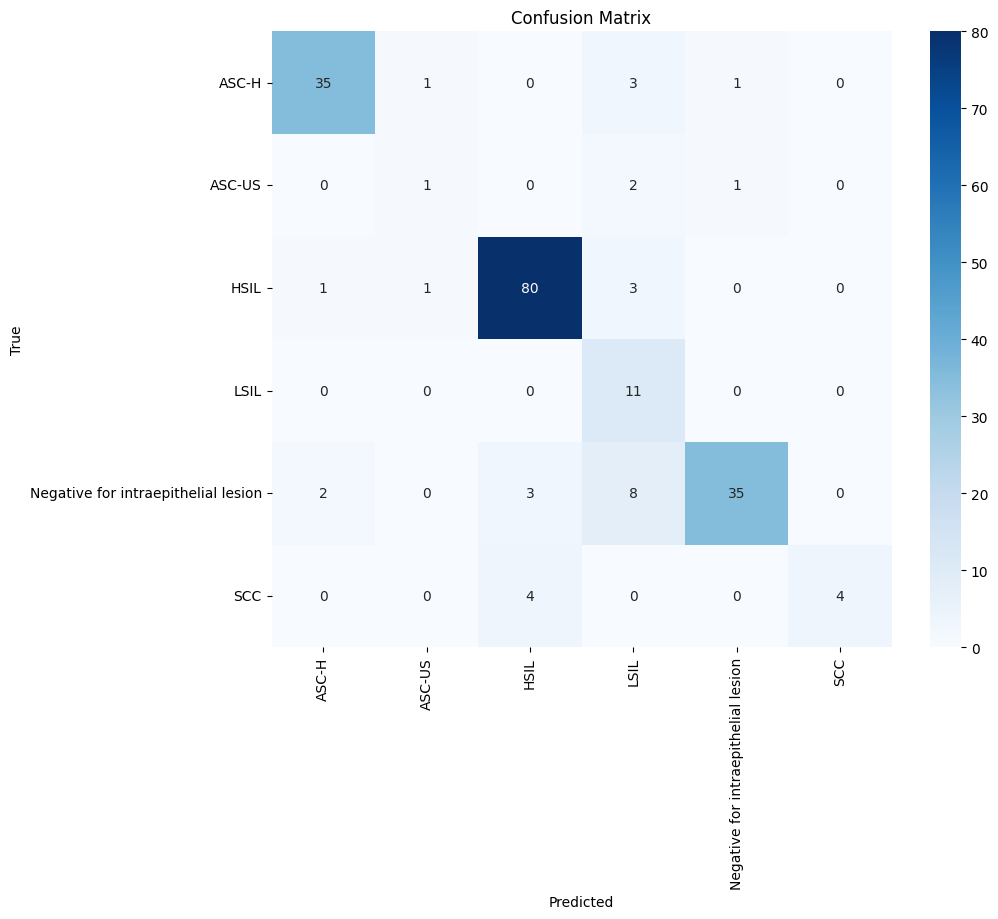

In [9]:
test_loss, test_accuracy, test_precision, test_recall, test_f1, all_labels, all_preds = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Plot da matriz de confusão
plot_confusion_matrix(all_labels, all_preds, list(dataset.class_to_idx.keys()))